# Match between Newtonian Chirp and numerical GR waveform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [2]:
import scipy.fft as fft
import scipy.signal as signal

In [27]:
import pycbc.waveform

## Functions

In [4]:
def get_hp(m1, m2, d, time_step, model="EOBNRv2", f_lower=14):
    
    # waveform (plus and cross polarization)
    hp, hc = pycbc.waveform.get_td_waveform(
        approximant = model, 
        mass1       = m1, 
        mass2       = m2, 
        distance    = d, 
        f_lower     = f_lower, 
        delta_t     = time_step
    )

    hp = hp.numpy()
    hc = hc.numpy()

    return hp, hc

In [5]:
def get_hpt(hp, tol=1e-23):
    i_max = np.argmax(np.abs(hp))

    # data after coalescence
    hp_ = hp[i_max:]

    # tolerance
    eps = tol

    # check all points within tolerance
    a = hp_ < eps
    a = a.astype(int)

    # take the first point within tolerance (first point closest to zero)
    j_zero = np.argmax(a)

    # take points until first zero after coalescence
    hpt = hp[:i_max + j_zero + 1]

    hpt = np.concatenate(
        (hpt, [0])
    )

    return hpt

In [6]:
distances = np.array(
    [40, 440, 4400, 20*10**(3), 44*10**(3), 100*10**(3), 440*10**3, 4400*10**3, 44*10**6, 440*10**6]
)

---

### numerical GR waveform

In [7]:
# time
time_step = 10**(-5)

In [8]:
# chirp parameter
m1 = 35.6 # solar masses
m2 = 30.6 # solar masses
# d  = 440  # Mpc
hp_list = []
for d in distances:
    hp, _ = get_hp(m1, m2, d, time_step, f_lower=10.85263)
    hp_list.append(hp)

hp_array = np.array(hp_list)

print("Shape:", hp_array.shape)

Shape: (10, 415861)


In [9]:
hpt_list = []
for hp in hp_array:
    hpt = get_hpt(hp)
    hpt_list.append(hpt)

hpt_array = np.array(hpt_list)
print("Shape:", hpt_array.shape)

Shape: (10, 400000)


In [10]:
length = hpt_array.shape[1]
t = np.linspace(-4, 0, length)

In [11]:
hpw_list = []

# window function
for hpt in hpt_array:
    w = signal.windows.tukey(len(hpt), alpha=0.25, sym=True)

    # cutting window right edge
    w1 = np.where(t > -1, 1, w)

    hpw = hpt * w1

    hpw_list.append(hpw)

hpw_array = np.array(hpw_list)

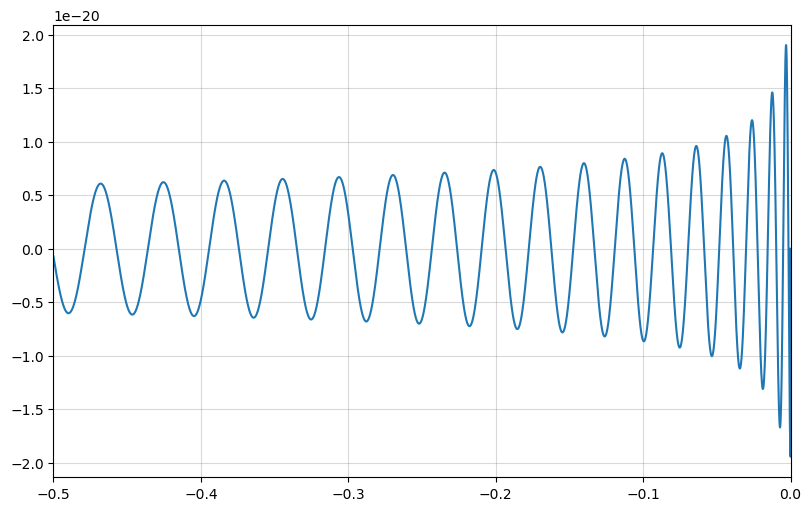

In [12]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.grid(True, axis="both", which="major", color="grey", alpha=0.3)
ax.plot(t, hpw_array[0])

ax.set_xlim(-0.5, 0)

plt.show()

In [13]:
hpf_list = []
for hpw in hpw_array:
    hpf = fft.rfft(hpw, norm="backward")
    hpf_list.append(hpf)

hpf_array = np.array(hpf_list)
print("Fourier-transformed signal shape:", hpf_array.shape)

Fourier-transformed signal shape: (10, 200001)


In [14]:
# corresponding frequencies
delta_f = 1./(length * time_step)

f = delta_f * np.arange(0, length/2 + 1)

print("DELTA EFFE", delta_f)

DELTA EFFE 0.25


In [15]:
# import sensitivity 
sens_data = np.loadtxt("SensitivityData/L1_O3.txt")

freq, sens = sens_data.T

print("Frequency shape", freq.shape)

Frequency shape (19961,)


In [16]:
f_filtered = []
i_filtered = []
for i, ff in enumerate(f):
    if ff in freq:
        f_filtered.append(ff)
        i_filtered.append(i)

In [17]:
fsignal_filtered_list = []

for hpf in hpf_array:
    fsignal_filtered = hpf[i_filtered] / sens
    fsignal_filtered_list.append(fsignal_filtered)

fsignal_filtered_array = np.array(fsignal_filtered_list)

In [18]:
tsignal_filtered_list = []

for fsignal_filtered in fsignal_filtered_array:
    tsignal_filtered = fft.irfft(fsignal_filtered)
    tsignal_filtered_list.append(tsignal_filtered)

tsignal_filtered_array = np.array(tsignal_filtered_list)

(10, 39920)

In [19]:
t_filtered = np.linspace(-4, 0, tsignal_filtered_array.shape[1])

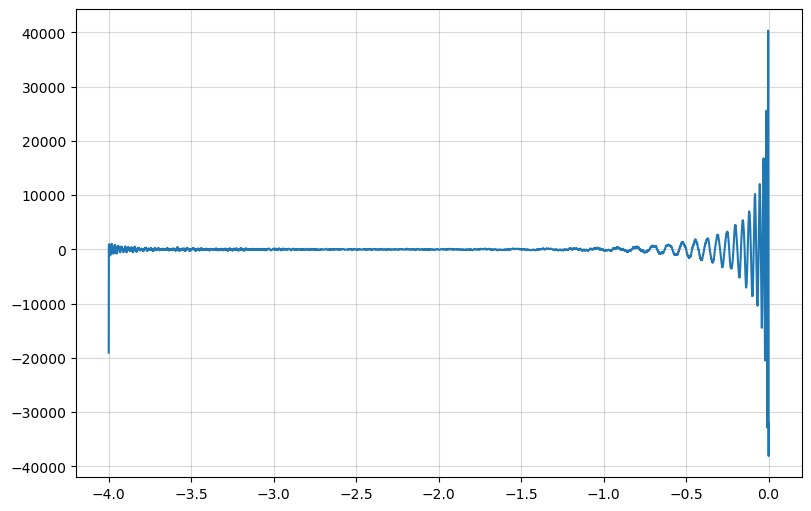

In [20]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.grid(True, axis="both", which="major", color="grey", alpha=0.3)
ax.plot(t_filtered, tsignal_filtered_array[0])

plt.show()

In [21]:
# filtered signals PSD
psd_list = []
for tsignal_filtered in tsignal_filtered_array:
    psd = np.abs(tsignal_filtered)**2
    psd_list.append(psd)

psd_array = np.array(psd_list)

In [22]:
snr = np.sqrt(np.real(4*np.sum(psd_array, axis=1)*delta_f))

In [23]:
N = 100

In [24]:
tsignal_filtered_array_expanded = np.expand_dims(tsignal_filtered_array, 1)

tsignal_filtered_array_repeated = np.repeat(tsignal_filtered_array_expanded, N, 1)

In [25]:
# signals in noise

# bkgs
bkgs = np.random.randn(N, tsignal_filtered_array.shape[1])

noisy_tsignal_array = np.add(
    bkgs, tsignal_filtered_array_repeated
)

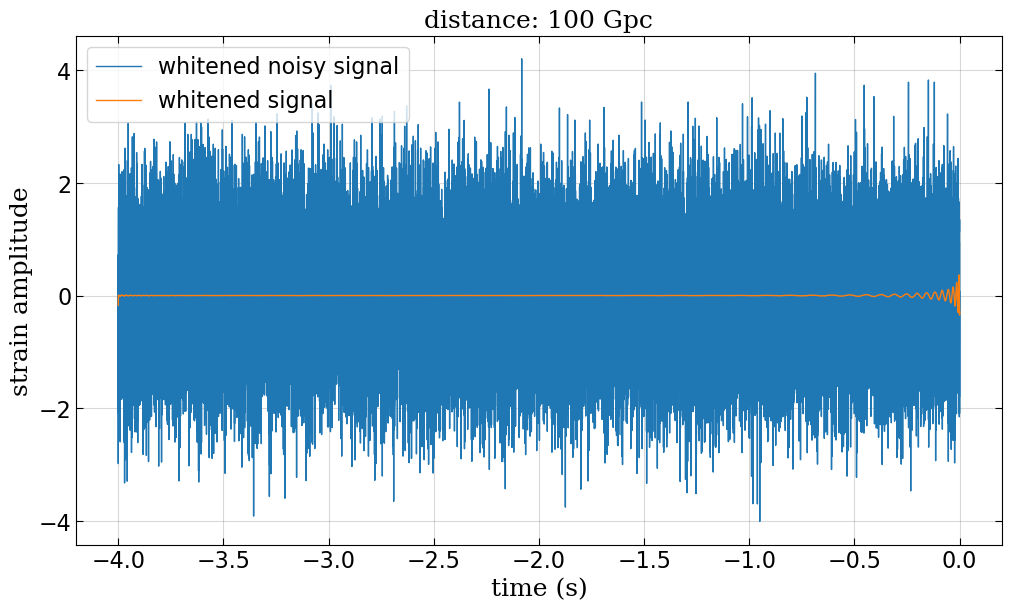

In [26]:
n_sig = 7

fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
ax.grid(True, axis="both", which="major", color="grey", alpha=0.3)
ax.plot(t_filtered, noisy_tsignal_array[n_sig,0,:], linewidth=1, label='whitened noisy signal')
ax.plot(t_filtered, tsignal_filtered_array[n_sig,:], linewidth=1, label='whitened signal')
ax.set_xlabel('time (s)', fontdict={'fontfamily':'serif', 'fontsize':18})
ax.set_ylabel('strain amplitude', fontdict={'fontfamily':'serif', 'fontsize':18})
ax.set_title('distance: 100 Gpc', fontdict={'fontfamily':'serif', 'fontsize':18})

ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, size=5, labelsize=16)

# legend
ax.legend(loc='upper left', prop={'size' : 16})

# ax.set_xlim(-0.5, 0)
# ax.set_ylim(-45,45)

plt.show()

### Newtonian waveform

In [28]:
import astropy.constants as const

In [29]:
# constants 
G   = const.G.value         # N m^2/kg^2
M_S = const.M_sun.value     # kg
C   = const.c.value         # m/s

In [30]:
t_0   = 0  # time of coalescence (s)

# phase at coalescence (radian)
phi = np.pi / 2

In [31]:
# functions

def chirp_mass_sm(m_1, m_2):
    return pow(m_1*m_2, 3/5) * pow(m_1+m_2, -1/5)

def chirp_mass(a,b):
    return pow(a*b, 3/5) * pow(a+b, -1/5)

def max_f(m_tot):
    return pow(2 * np.pi * np.sqrt(2), -1) * pow(G * M_S / (pow(C,3)), -1) * M_S / m_tot     

def frequency(f0, mc):
    return pow( pow(f0, -8/3) - 256/5 * pow(np.pi, 8/3) * pow(mc / M_S, 5/3) * pow((G*M_S)/pow(C,3), 5/3) * (t-t_0), -3/8 )

def a_factor(dist, m1sm, m2sm):
    return 4*C/dist * pow(G*M_S, 5/3) * pow(C, -5) * m1sm * m2sm * pow(m1sm+m2sm, -1/3)

def b_factor(freq):
    return pow(np.pi * freq, 2/3)

def strain(x,f):
    return np.cos(2 * np.pi * f * x + phi)

In [37]:
# chirp parameters
m1_sm = 35.6                      # compact object 1 mass (units of solar masses)
m2_sm = 30.6                      # compact object 2 mass (units of solar masses)
m1    = m1_sm * M_S               # compact object 1 mass (kg)
m2    = m2_sm * M_S               # compact object 2 mass (kg)
m     = m1 + m2                   # total mass
d_pc  = 440 * 10**6               # distance (pc)
d     = d_pc * 3.086 * 10**(16)   # distance (m)

# chirp mass (solar masses)
mc_sm = chirp_mass_sm(m1_sm,m2_sm)
mc = chirp_mass(m1,m2)

# maximum frequency in the merger (Hz)
f_0 = max_f(m)   

# frequency
f = frequency(f_0, mc)

h = strain(t,f)

b = b_factor(f)
a_factors = a_factor(distances, m1_sm, m2_sm)

# whitening
chirps = np.array([b*h*af for af in a_factors])

fchirps = fft.rfft(chirps)

fchirps_filtered = fchirps[:, i_filtered] / sens

tchirps_filtered = fft.irfft(fchirps_filtered)

In [38]:
avg_match = []
std_match = []

for chirp_signal, noisy_signal in zip(tchirps_filtered, noisy_tsignal_array):
    
    chirp_norm = np.linalg.norm(chirp_signal)
    match_bkg = []
    for noisy_signal_bkg in noisy_signal:
        noisy_norm = np.linalg.norm(noisy_signal_bkg)
        match_ = np.dot(noisy_signal_bkg, chirp_signal) / (noisy_norm * chirp_norm)

        match_bkg.append(match_)
    
    avg = np.mean(match_bkg)
    std = np.std(match_bkg)

    avg_match.append(avg)
    std_match.append(std)

avg_match = np.array(avg_match)
std_match = np.array(std_match)

In [ ]:
matches = []

for chirp_signal, noisy_signal in zip(tchirps_filtered, noisy_tsignal_array):
    
    chirp_norm = np.linalg.norm(chirp_signal)
    match_bkg = []
    for noisy_signal_bkg in noisy_signal:
        noisy_norm = np.linalg.norm(noisy_signal_bkg)
        match_ = np.dot(noisy_signal_bkg, chirp_signal) / (noisy_norm * chirp_norm)

        match_bkg.append(match_)
    
    matches.append(match_bkg)

matches_array = np.array(matches)

In [40]:
labels = [ 'GW150914 (d = 44 Mpc)',
          'GW150914 (d = 440 Mpc, original)',
        'GW150914 (d = 4400 Mpc)',
        'GW150914 (d = 20 Gpc)',
        'GW150914 (d = 44 Gpc)',
        'GW150914 (d = 100 Gpc)',
        'GW150914 (d = 440 Gpc)',
        'GW150914 (d = 4400 Gpc)',
        'GW150914 (d = 44 Tpc)',
        'GW150914 (d = 440 Tpc)' ]

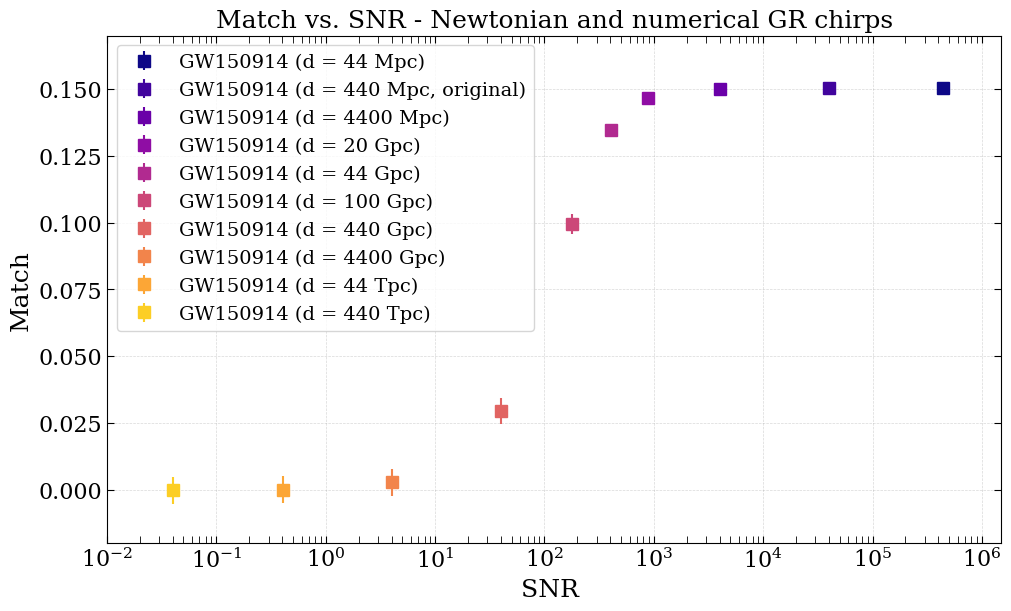

In [41]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family']      = 'serif'

fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)

ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.3) 
ax.set_axisbelow(True)

for i in range(0, 10):

    ax.errorbar(snr[i], np.mean(matches_array, axis=1)[i], yerr=np.std(matches_array, axis=1)[i], color=plt.cm.plasma(i/10), marker="s", label=labels[i], ls="", markersize=8)


ax.set_xlabel('SNR ', fontdict={'fontfamily':'serif', 'fontsize':18})
ax.set_ylabel('Match', fontdict={'fontfamily':'serif', 'fontsize':18})
ax.set_title('Match vs. SNR - Newtonian and numerical GR chirps', fontdict={'fontfamily':'serif', 'fontsize':18})

ax.set_xscale("log")

ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, size=5, labelsize=16)

ax.legend( loc='best', prop={'size': 14})

# axis limits
ax.set_xlim(10**(-2), 1.5*10**6)
ax.set_ylim(-0.02, 0.17)

plt.show()

In [43]:
fig.savefig("../../slides/fp2.png", dpi=500, facecolor="white")

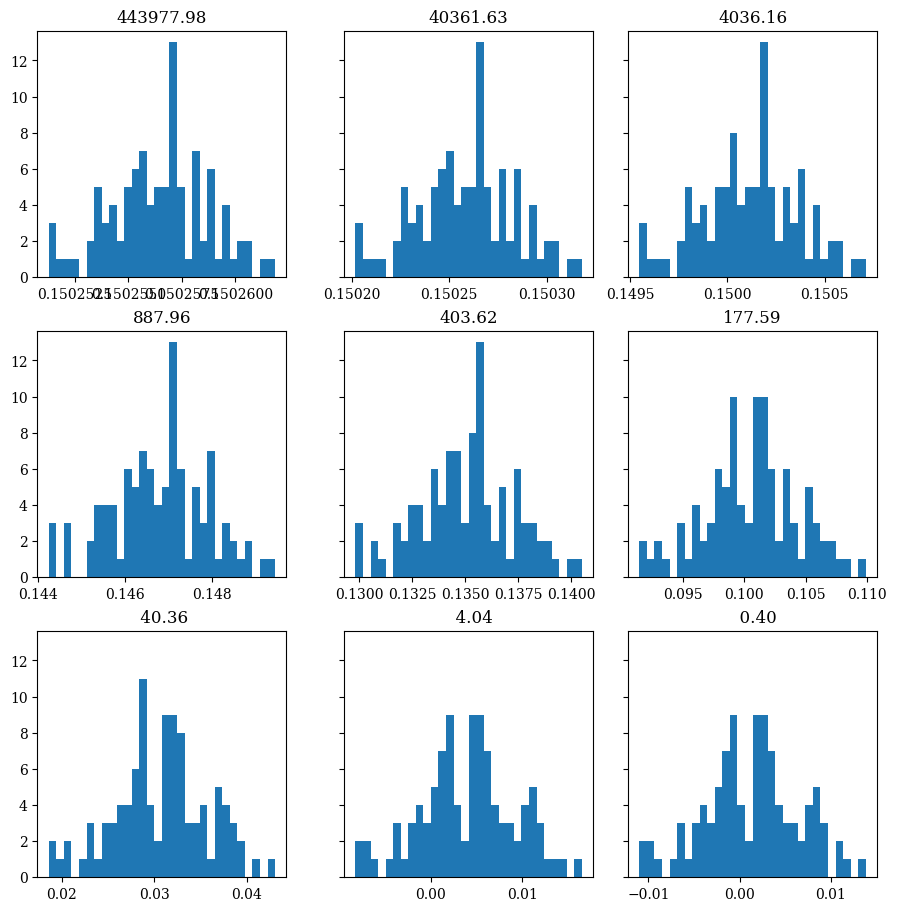

In [44]:
# distribuzioni dei match

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,9), constrained_layout=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.hist(matches[i], bins=30)

    ax.set_title(f"{snr[i]:6.2f}")

    ax.get_xaxis().get_major_formatter().set_useOffset(False)

    # ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    # ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))

plt.show()

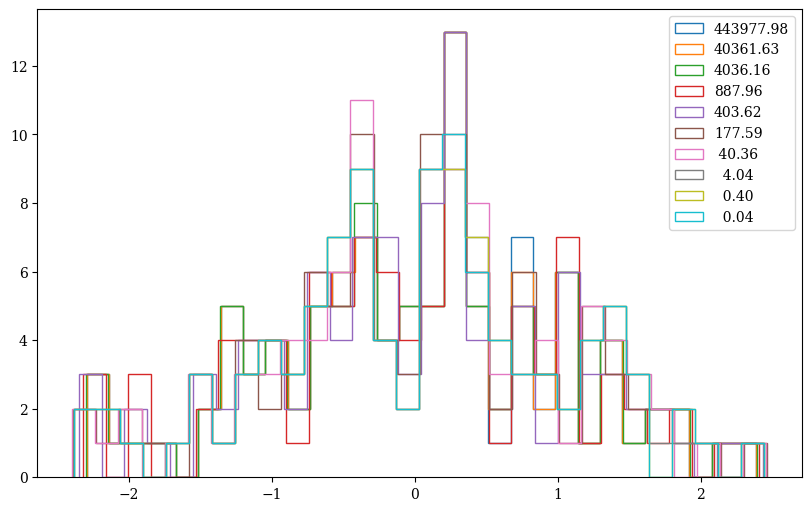

In [45]:
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

for i, m in enumerate(matches_array):

    avg = np.mean(m)
    std = np.std(m)

    ax.hist((m-avg)/std, bins=30, histtype="step", label=f"{snr[i]:6.2f}")

ax.legend()
plt.show()